<a href="https://colab.research.google.com/github/Kotlasrinivas5121/Data-Science-and-Decision-Making/blob/main/FineTuning_DenseNet_on_CT_scan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1.0 Imports

In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample

from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications import DenseNet201


from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [ ]:
import os
os.chdir("/content/drive/MyDrive/Covid19_CTscan_classification")

### 2.0 Loading and Exploring the data

In [ ]:
disease_types=['CT_COVID', 'CT_NonCOVID']
data_dir = 'data'
train_dir = os.path.join(data_dir)

In [ ]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

,File,DiseaseID,Disease Type
0,CT_COVID/2020.02.27.20027557-p25-137%0.png,0,CT_COVID
1,CT_COVID/2020.02.10.20021584-p6-52%0 (1).png,0,CT_COVID
2,CT_COVID/2020.03.16.20035105-p6-64-2.png,0,CT_COVID
3,CT_COVID/2020.02.22.20024927-p19-68%3 (1).png,0,CT_COVID
4,CT_COVID/2020.03.10.20032136-p34-118_2%0.png,0,CT_COVID


In [ ]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,CT_NonCOVID/1%2.jpg,1,CT_NonCOVID
1,CT_COVID/2020.03.19.20038539-p10-58.png,0,CT_COVID
2,CT_NonCOVID/11%0.jpg,1,CT_NonCOVID
3,CT_NonCOVID/2041.png,1,CT_NonCOVID
4,CT_NonCOVID/2140.png,1,CT_NonCOVID


In [ ]:
def show_images(class_name = None, rows = 10, columns = 10):
    images_to_load = rows * columns
    
    if class_name == "Covid":
        path = os.path.join(data_dir, "CT_COVID")
        images_path = os.listdir(path)
        chosen_random_images_path = sample(images_path, images_to_load)
        
    elif class_name == "non_covid":
        path = os.path.join(data_dir, "CT_NonCOVID")
        images_path = os.listdir(path)
        chosen_random_images_path = sample(images_path, images_to_load)
        
    fig = plt.figure(figsize=(16, 16))
    for i in range(1, columns*rows +1):
        image_path = os.path.join(path, chosen_random_images_path[i - 1])
        BGR_image = cv2.imread(image_path)
        RGB_image = cv2.cvtColor(BGR_image, cv2.COLOR_BGR2RGB)
        fig.add_subplot(rows, columns, i)
        plt.imshow(RGB_image)
        plt.axis('off')

    plt.show()

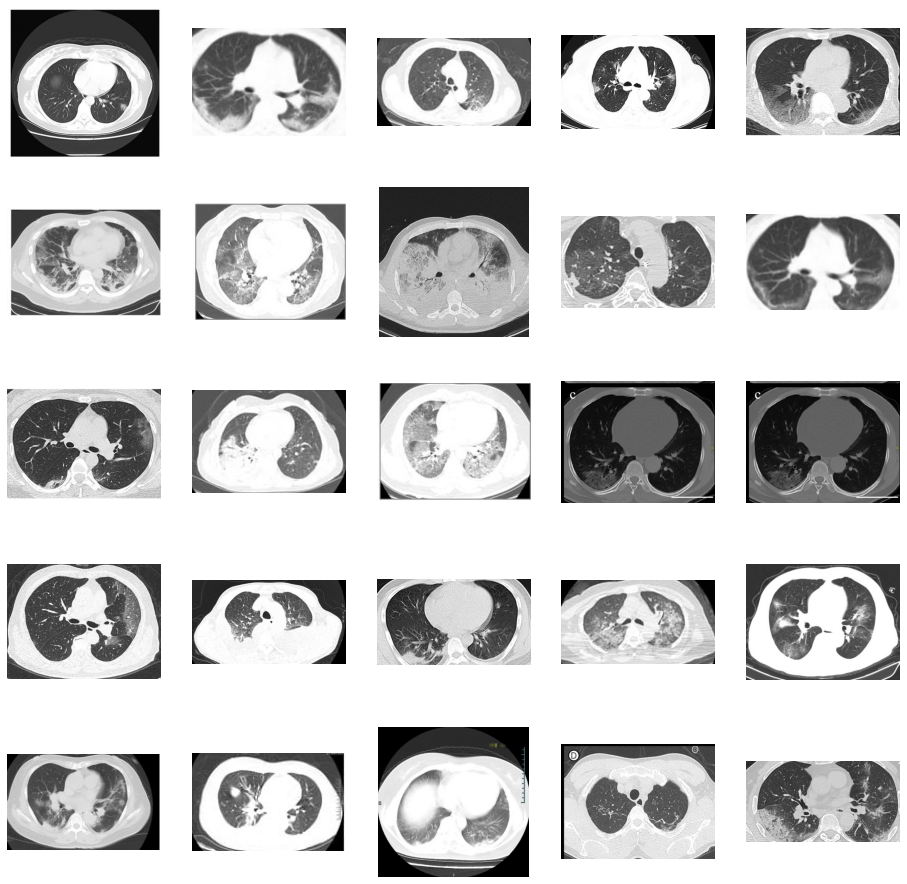

In [ ]:
show_images(class_name = "Covid", rows = 5, columns = 5)

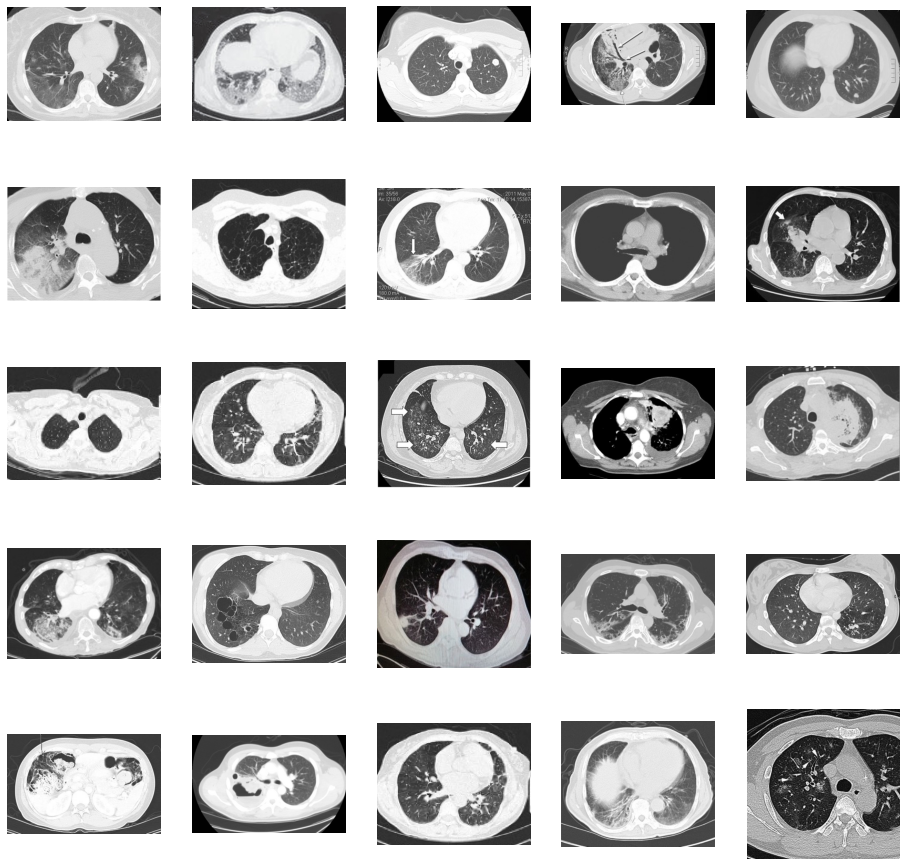

In [ ]:
show_images(class_name = "non_covid", rows = 5, columns = 5)

### 3.0 Data Preprocessing and Feature Engineering 

In [ ]:
IMAGE_SIZE = 224

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) 

def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))

X_Train = X_train / 255.0
print('Train Shape: {}'.format(X_Train.shape))

756it [00:06, 113.48it/s]


Train Shape: (756, 224, 224, 3)


In [ ]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)
print(Y_train.shape)

(756, 2)


In [ ]:
BATCH_SIZE = 32

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

### 4.0 FineTuning the DenseNet model and Training

In [ ]:
EPOCHS = 150
SIZE=224
N_ch=3

In [ ]:
def build_resnet50():
    densetnet201 = DenseNet201(weights='imagenet', include_top=False)

    input = Input(shape=(224, 224, 3))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densetnet201(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)


    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
model = build_resnet50()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=10, verbose=1, min_lr=1e-6)

checkpoint = ModelCheckpoint('model.h5',
                             monitor="val_accuracy",
                             verbose=1,
                             save_best_only=True)

datagen = ImageDataGenerator(rotation_range=20,
                        width_shift_range=0.2, 
                        height_shift_range=0.2,
                        horizontal_flip=True)
datagen.fit(X_train)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 3)       84        
_________________________________________________________________
densenet201 (Functional)     (None, None, None, 1920)  18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
_________________________________________________________________
dense (Dense)                (None, 128)               245888    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512   

In [ ]:
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
18/18 [==============================] - 72s 2s/step - loss: 0.8248 - accuracy: 0.6014 - val_loss: 0.6447 - val_accuracy: 0.6842

Epoch 00001: val_accuracy improved from -inf to 0.68421, saving model to model.h5
Epoch 2/150
18/18 [==============================] - 23s 1s/step - loss: 0.5858 - accuracy: 0.7430 - val_loss: 0.6535 - val_accuracy: 0.6053

Epoch 00002: val_accuracy did not improve from 0.68421
Epoch 3/150
18/18 [==============================] - 23s 1s/step - loss: 0.4338 - accuracy: 0.8094 - val_loss: 0.6746 - val_accuracy: 0.5789

Epoch 00003: val_accuracy did not improve from 0.68421
Epoch 4/150
18/18 [==============================] - 23s 1s/step - loss: 0.3844 - accuracy: 0.8112 - val_loss: 0.6310 - val_accuracy: 0.6579

Epoch 00004: val_accuracy did not improve from 0.68421
Epoch 5/150
18/18 [==============================] - 23s 1s/step - loss: 0.3061 - accuracy: 0.8566 - val_loss: 0.6259 - val_accuracy: 0.6711

Epoch 00005: val_accuracy did not improve f

## 5.0 Transfer Learning using DenseNet

In [ ]:
EPOCHS = 200
BATCH_SIZE = 8

In [ ]:
input = Input(shape=(224, 224, 3))

DenseNet = DenseNet201(include_top=True,
                    weights="imagenet",
                    input_tensor=input)
DenseNet.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
# building the transfer learning model
last_layer = DenseNet.get_layer('avg_pool').output

out = Dense(units = 2,
            activation='softmax',
            name='output')(last_layer)  

denseNet_model_TL = Model(input, out)

for layer in denseNet_model_TL.layers[:-1]:
	layer.trainable = False

denseNet_model_TL.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=10, verbose=1, min_lr=1e-6)

checkpoint = ModelCheckpoint('DenseNet_TL.h5',
                             monitor="val_accuracy",
                             verbose=1,
                             save_best_only=True)

datagen = ImageDataGenerator(rotation_range=20,
                        width_shift_range=0.2, 
                        height_shift_range=0.2,
                        horizontal_flip=True)
datagen.fit(X_train)

In [ ]:
# compiling the model
optimizer = Adam(lr=0.003,
                 beta_1=0.9,
                 beta_2=0.999,
                 epsilon=0.1,
                 decay=0.0)

denseNet_model_TL.compile(loss='categorical_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
hist = denseNet_model_TL.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
                                    steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                                    epochs=EPOCHS,
                                    verbose=1,
                                    callbacks=[annealer, checkpoint],
                                    validation_data=(X_val, Y_val))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
75/75 [==============================] - 39s 313ms/step - loss: 0.6937 - accuracy: 0.5973 - val_loss: 0.6538 - val_accuracy: 0.6447

Epoch 00001: val_accuracy improved from -inf to 0.64474, saving model to DenseNet_TL.h5
Epoch 2/200
75/75 [==============================] - 12s 158ms/step - loss: 0.5998 - accuracy: 0.6745 - val_loss: 0.5879 - val_accuracy: 0.6776

Epoch 00002: val_accuracy improved from 0.64474 to 0.67763, saving model to DenseNet_TL.h5
Epoch 3/200
75/75 [==============================] - 12s 159ms/step - loss: 0.5360 - accuracy: 0.7383 - val_loss: 0.5676 - val_accuracy: 0.7039

Epoch 00003: val_accuracy improved from 0.67763 to 0.70395, saving model to DenseNet_TL.h5
Epoch 4/200
75/75 [==============================] - 12s 159ms/step - loss: 0.4714 - accuracy: 0.7903 - val_loss: 0.5148 - val_accuracy: 0.7500

Epoch 00004: val_accuracy improved from 0.70395 to 0.75000, saving model to DenseNet_TL.h5
Epoch 5/200
75/75 [==============================] - 12s 15

In [ ]:
# loading the best model
checkpoint_path = "DenseNet_TL.h5"
denseNet_model_TL.load_weights(checkpoint_path)

In [ ]:
# getting precision, recall, f1 score and auc score
yhat_probs = denseNet_model_TL.predict(X_val, verbose=0)
yhat_classes = np.argmax(yhat_probs, axis=1)
 
test_precision_TL = precision_score(Y_val[..., 1], yhat_classes)
test_recall_TL = recall_score(Y_val[..., 1], yhat_classes)
test_auc_TL = roc_auc_score(Y_val[..., 1], yhat_classes)
test_f1_TL = f1_score(Y_val[..., 1], yhat_classes)

##  6.0 Performance Metrics

In [ ]:
# loading the best model
checkpoint_path = "model.h5"
model.load_weights(checkpoint_path)

In [ ]:
# evaluating the model on the test data
loss, acc = model.evaluate(X_val, Y_val, verbose=2)
print("Accuracy on test data: {:5.2f}%".format(100 * acc))

5/5 - 2s - loss: 0.3322 - accuracy: 0.9079
Accuracy on test data: 90.79%


In [ ]:
# evaluating the model on the training data data
loss, acc = model.evaluate(X_train, Y_train, verbose=2)
print("Accuracy on training data: {:5.2f}%".format(100 * acc))

19/19 - 6s - loss: 0.0045 - accuracy: 0.9983
Accuracy on training data: 99.83%


In [ ]:
# getting precision, recall, f1 score and auc score
yhat_probs = model.predict(X_val, verbose=0)
yhat_classes = np.argmax(yhat_probs, axis=1)
 
test_precision = precision_score(Y_val[..., 1], yhat_classes)
test_recall = recall_score(Y_val[..., 1], yhat_classes)
test_auc = roc_auc_score(Y_val[..., 1], yhat_classes)
test_f1 = f1_score(Y_val[..., 1], yhat_classes)

In [ ]:
# initialise data of lists.
data = {'Metrics':['Training Accuracy', 'Test Accuracy', 'Precision', "recall", "F1 score", "AUC"],
        "Transfer Learning DenseNet": [ 0.92, 0.79, test_precision_TL, test_recall_TL, test_f1_TL, test_auc_TL],
       "Fine Tuning DenseNet202 model" : [0.998, 0.98, test_precision, test_recall, test_f1, test_auc]}
 
# Create DataFrame
df = pd.DataFrame(data)

In [ ]:
# the table
df

,Metrics,Transfer Learning DenseNet,Fine Tuning DenseNet202 model
0,Training Accuracy,0.920000,0.998000
1,Test Accuracy,0.790000,0.980000
2,Precision,0.835443,0.948718
3,recall,0.785714,0.880952
4,F1 score,0.809816,0.913580
5,AUC,0.797269,0.911064
